# [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic/overview)

## Loading in the data

In [859]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from scipy.stats import boxcox, shapiro, chi2_contingency, kruskal, f_oneway
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

In [171]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

trainID = train_raw['PassengerId'].values
testID = test_raw['PassengerId'].values

All = train_raw.append(test_raw, ignore_index=True)
print(All.describe(include = 'all'))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


                Age        Cabin Embarked         Fare              Name  \
count   1046.000000          295     1307  1308.000000              1309   
unique          NaN          186        3          NaN              1307   
top             NaN  C23 C25 C27        S          NaN  Kelly, Mr. James   
freq            NaN            6      914          NaN                 2   
mean      29.881138          NaN      NaN    33.295479               NaN   
std       14.413493          NaN      NaN    51.758668               NaN   
min        0.170000          NaN      NaN     0.000000               NaN   
25%       21.000000          NaN      NaN     7.895800               NaN   
50%       28.000000          NaN      NaN    14.454200               NaN   
75%       39.000000          NaN      NaN    31.275000               NaN   
max       80.000000          NaN      NaN   512.329200               NaN   

              Parch  PassengerId       Pclass   Sex        SibSp    Survived  \
count  

In [172]:
All.head()


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [173]:
All.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

## Feature Engineering and Dealing with Missing Values
Cabin has mostly empty values so it will be dropped.

In [174]:
All.isna().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [175]:
All[All['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [176]:
All[All['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


The Pclass seems like it would be the best predictor for Fare since it is a proxy for socio-economic status. Hence I will impute the median value of the Pclass of the NaN entry. 

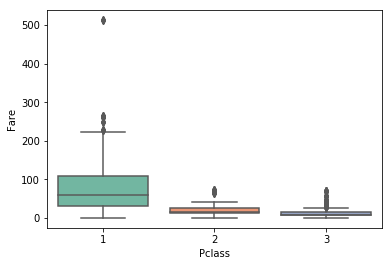

In [177]:
bp = sns.boxplot(y='Fare', x = 'Pclass',data=All , palette='Set2')

The missing Embarked values are probably C since the fare is high, just like the fare values of the two NaNs. 

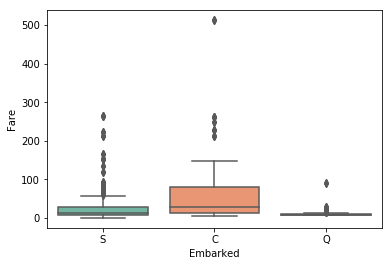

In [178]:
bp = sns.boxplot(y='Fare', x = 'Embarked',data=All , palette='Set2')

In [179]:
All.groupby('Pclass')['Fare'].median()

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

In [180]:
All.groupby('Embarked')['Fare'].median()

Embarked
C    28.51875
Q     7.75000
S    13.00000
Name: Fare, dtype: float64

In [181]:
All['Fare'].fillna(8.0500, inplace=True)
All['Embarked'].fillna('C', inplace=True)
All.drop(columns='Cabin', inplace=True)

### Name and Ticket Prefixes
At first the Name and Ticket columns don't look all that useful, but maybe there is some useful prefixes in these columns.

In [183]:
All['Ticket Prefix'] = ''
for i in range(len(All)):
    if len(All['Ticket'].str.split()[i]) > 1:
        All['Ticket Prefix'].iloc[i] = All['Ticket'].str.split()[i][0]
    else:
        All['Ticket Prefix'].iloc[i] = 'None'


In [184]:
All['Name Prefix'] = All['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]

One prefix has evaded me, so I will check for it individually.

In [185]:
All['Name Prefix'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Mlle          2
Don           1
th            1
Jonkheer      1
Mme           1
Dona          1
Sir           1
Capt          1
Lady          1
Name: Name Prefix, dtype: int64

In [186]:
All[All['Name Prefix'] == 'th']

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket Prefix,Name Prefix
759,33.0,S,86.5,"Rothes, the Countess. of (Lucy Noel Martha Dye...",0,760,1,female,0,1.0,110152,None,th


In [187]:
All.loc[All['Name Prefix'] == 'th', 'Name Prefix'] = 'Countess'

In [188]:
All['Name Prefix'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Dona          1
Lady          1
Sir           1
Mme           1
Countess      1
Don           1
Capt          1
Jonkheer      1
Name: Name Prefix, dtype: int64

In [189]:
All.groupby('Name Prefix')['Survived'].mean()

Name Prefix
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dona             NaN
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [190]:
All.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Keeping the above table in mind as well as using [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) for the lesser known prefixes, I will merge together name prefixes with small sample sizes. [Encyclopedia-titanica](https://www.encyclopedia-titanica.org/) also proved to be helpful for looking up certain passengers.

In [191]:
All['Name Prefix'] = All['Name Prefix'].replace(['Capt','Col','Don','Major','Rev','Sir','Jonkheer'],'Mr')
All['Name Prefix'] = All['Name Prefix'].replace(['Countess','Dona','Lady'],'Mrs')
All['Name Prefix'] = All['Name Prefix'].replace(['Mlle','Mme','Ms'],'Miss')
All.loc[(All['Name Prefix'] == 'Dr') & (All['Sex'] == 'female'),'Name Prefix'] = 'Miss'
All.loc[(All['Name Prefix'] == 'Dr') & (All['Sex'] == 'male'),'Name Prefix'] = 'Mr'

In [192]:
All['Name Prefix'].value_counts()

Mr        782
Miss      266
Mrs       200
Master     61
Name: Name Prefix, dtype: int64

In [193]:
All['Ticket Prefix'].value_counts()

None          961
PC             92
C.A.           46
SOTON/O.Q.     16
W./C.          14
STON/O         14
A/5            12
CA.            12
SC/PARIS       11
A/5.           10
CA             10
F.C.C.          9
C               8
SOTON/OQ        8
S.O.C.          7
S.O./P.P.       7
STON/O2.        7
A/4             6
SC/Paris        5
SC/AH           5
PP              4
A.5.            3
F.C.            3
S.C./PARIS      3
A/4.            3
SOTON/O2        3
A./5.           3
SC              2
P/PP            2
WE/P            2
W.E.P.          2
STON/OQ.        1
C.A./SOTON      1
SC/A4           1
S.C./A.4.       1
S.O.P.          1
A/S             1
W/C             1
A4.             1
S.W./PP         1
SO/C            1
AQ/4            1
Fa              1
S.P.            1
SW/PP           1
SC/A.3          1
SCO/W           1
A.              1
AQ/3.           1
LP              1
Name: Ticket Prefix, dtype: int64

I don't want to overfit the data, so I'm only keeping a couple of these categories.

In [194]:
All.groupby('Ticket Prefix')['Survived'].mean()

Ticket Prefix
A.                 NaN
A./5.         0.000000
A.5.          0.000000
A/4           0.000000
A/4.          0.000000
A/5           0.100000
A/5.          0.142857
A/S           0.000000
A4.           0.000000
AQ/3.              NaN
AQ/4               NaN
C             0.400000
C.A.          0.481481
C.A./SOTON    0.000000
CA            0.000000
CA.           0.125000
F.C.          0.000000
F.C.C.        0.800000
Fa            0.000000
LP                 NaN
None          0.383459
P/PP          0.500000
PC            0.650000
PP            0.666667
S.C./A.4.     0.000000
S.C./PARIS    0.500000
S.O./P.P.     0.000000
S.O.C.        0.000000
S.O.P.        0.000000
S.P.          0.000000
S.W./PP       1.000000
SC            1.000000
SC/A.3             NaN
SC/A4              NaN
SC/AH         0.666667
SC/PARIS      0.400000
SC/Paris      0.500000
SCO/W         0.000000
SO/C          1.000000
SOTON/O.Q.    0.125000
SOTON/O2      0.000000
SOTON/OQ      0.142857
STON/O        0.4166

In [195]:
All.loc[(All['Ticket Prefix'] != 'C.A.') & (All['Ticket Prefix'] != 'PC'), 'Ticket Prefix'] = 'None of any importance'

In [196]:
All['Ticket Prefix'].value_counts()

None of any importance    1171
PC                          92
C.A.                        46
Name: Ticket Prefix, dtype: int64

### Family
Parch and SibSp can be added together as it looks like they might be related. I will call this Family for number of family members that are with the individual and cap it at 4.

In [200]:
All['Family'] = All['SibSp'] + All['Parch']

In [400]:
All.loc[All['PassengerId'].isin(trainID)].groupby('Family')['PassengerId'].count()

Family
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: PassengerId, dtype: int64

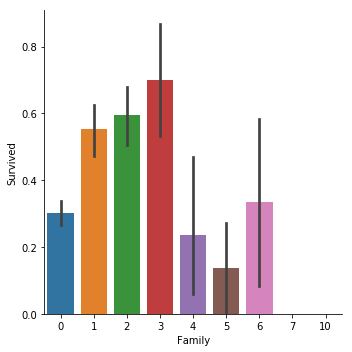

In [402]:
fp = sns.catplot(x='Family',y='Survived', data=All, kind='bar')

In [404]:
All['Family'] = All['Family'].apply(str)
All.loc[All['Family'].isin(['4','5','6','7','10']), 'Family'] = '4+'

### Filling in missing values for Age
Other than having the prefix Master or a large family size, there doesn't seem to be any good predictors for Age.

In [199]:
All.groupby('Name Prefix')['Age'].median()

Name Prefix
Master     4.0
Miss      22.0
Mr        30.0
Mrs       36.0
Name: Age, dtype: float64

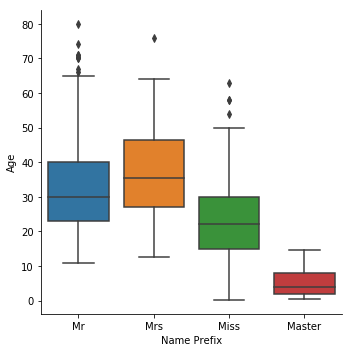

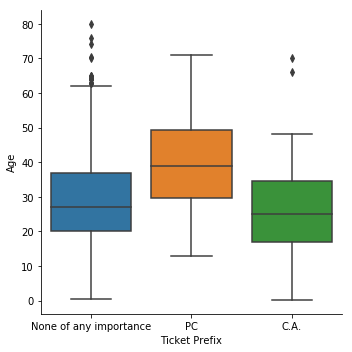

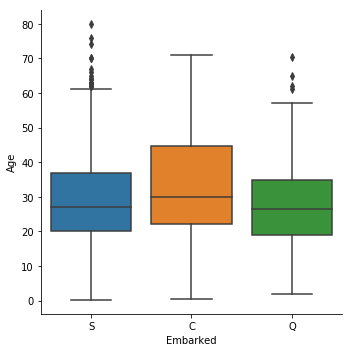

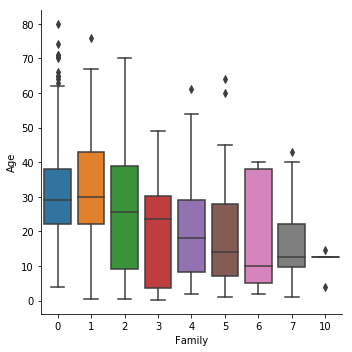

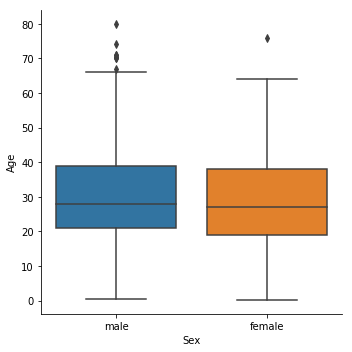

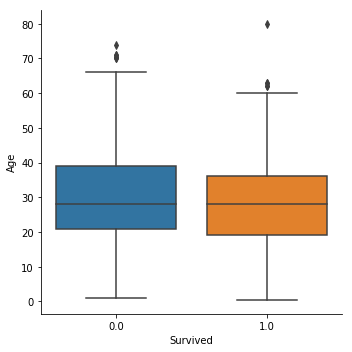

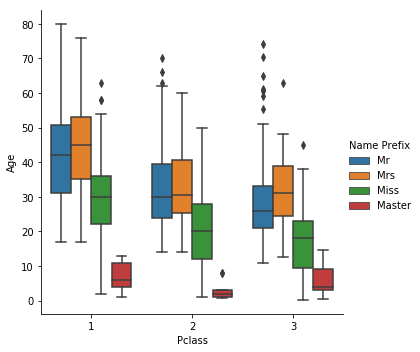

In [230]:
cp = sns.catplot(x='Name Prefix', y='Age',data=All,kind='box')
cp = sns.catplot(x='Ticket Prefix', y= 'Age', data=All, kind='box')
cp = sns.catplot(x='Embarked', y='Age', data=All, kind='box')
cp = sns.catplot(x='Family', y= 'Age', data=All, kind='box')
cp = sns.catplot(x='Sex', y='Age', data=All, kind='box')
cp = sns.catplot(x='Survived', y='Age', data=All, kind='box')
cp = sns.catplot(x='Pclass', y= 'Age', data=All, kind='box', hue='Name Prefix')

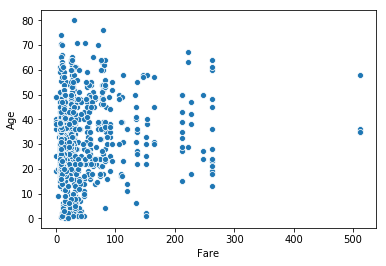

In [215]:
cp = sns.scatterplot(x='Fare', y='Age', data=All)

In [220]:
All.loc[(pd.isnull(All['Age']) )& (All['Name Prefix'] == 'Master'), 'Age'] = 4.0

In [227]:
All.loc[pd.isnull(All['Age'])&(All['Family'] >= 7), 'Age'] = All.loc[All['Family'] >= 7, 'Age'].median()

Other than those two predictors, the next best one seems to be the interaction of Name Prefix and Pclass.

In [233]:
pclass_vals = [1,2,3]
namepref_vals = ['Mr','Miss','Mrs']

for i in range(len(pclass_vals)):
    for j in range(len(namepref_vals)):
        All.loc[(pd.isnull(All['Age'])) & (All['Name Prefix'] == namepref_vals[j]) & (All['Pclass'] == pclass_vals[i]), 'Age'] \
        = All.loc[(All['Name Prefix'] == namepref_vals[j]) & (All['Pclass'] == pclass_vals[i]), 'Age'].median()
        
        

In [237]:
All.isna().sum()

Age                0
Embarked           0
Fare               0
Name               0
Parch              0
PassengerId        0
Pclass             0
Sex                0
SibSp              0
Survived         418
Ticket             0
Ticket Prefix      0
Name Prefix        0
Family             0
dtype: int64

Simply by looking at the tables below, I can see that the PassengerId of the 8 surviving test set boys are 1284,1199,1086,1309,956,1088,1053, and 981, as all (female and boy) family members lived(or at least the ones I have data for). 

In [291]:
All.loc[(All['Name Prefix']=='Master') & pd.isnull(All['Survived'])].sort_values(by='Surname')

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket Prefix,Name Prefix,Family,Surname,Group
1283,13.00,S,20.2500,"Abbott, Master. Eugene Joseph",2,1284,3,male,0,NaN,C.A. 2673,C.A.,Master,2,Abbott,Abbott
1198,0.83,S,9.3500,"Aks, Master. Philip Frank",1,1199,3,male,0,NaN,392091,None of any importance,Master,1,Aks,Aks
1270,5.00,S,31.3875,"Asplund, Master. Carl Edgar",2,1271,3,male,4,NaN,347077,None of any importance,Master,6,Asplund,Asplund
1045,13.00,S,31.3875,"Asplund, Master. Filip Oscar",2,1046,3,male,4,NaN,347077,None of any importance,Master,6,Asplund,Asplund
1230,4.00,C,7.2292,"Betros, Master. Seman",0,1231,3,male,0,NaN,2622,None of any importance,Master,0,Betros,Betros
971,6.00,C,15.2458,"Boulos, Master. Akar",1,972,3,male,1,NaN,2678,None of any importance,Master,2,Boulos,Boulos
1092,0.33,S,14.4000,"Danbom, Master. Gilbert Sigvard Emanuel",2,1093,3,male,0,NaN,347080,None of any importance,Master,2,Danbom,Danbom
1085,8.00,S,32.5000,"Drew, Master. Marshall Brines",2,1086,2,male,0,NaN,28220,None of any importance,Master,2,Drew,Drew
1135,4.00,S,23.4500,"Johnston, Master. William Arthur Willie""""",2,1136,3,male,1,NaN,W./C. 6607,None of any importance,Master,3,Johnston,Johnston
912,9.00,S,3.1708,"Olsen, Master. Artur Karl",1,913,3,male,0,NaN,C 17368,None of any importance,Master,1,Olsen,Olsen


## Taking a big hint
According to this [kernel](https://www.kaggle.com/c/titanic/discussion/57447), any model can be greatly improved by simply doing a couple extra steps outlined in the link.

In [264]:
All['Surname'] = All['Name'].str.split(',', expand=True)[0]

In [269]:
All['Group'] = All['Surname']
All.loc[All['Name Prefix'] == 'Mr', 'Group'] = 'not relevant'

In [285]:
test_boy_surnames = All.loc[(All['Name Prefix']=='Master') & pd.isnull(All['Survived']), 'Group'].values.tolist()

In [290]:
All.loc[All['Group'].isin(test_boy_surnames),['Name','Surname','PassengerId','Survived']].sort_values(by=['Surname','PassengerId'])

,Name,Surname,PassengerId,Survived
279,"Abbott, Mrs. Stanton (Rosa Hunt)",Abbott,280,1.0
1283,"Abbott, Master. Eugene Joseph",Abbott,1284,NaN
855,"Aks, Mrs. Sam (Leah Rosen)",Aks,856,1.0
1198,"Aks, Master. Philip Frank",Aks,1199,NaN
25,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",Asplund,26,1.0
182,"Asplund, Master. Clarence Gustaf Hugo",Asplund,183,0.0
233,"Asplund, Miss. Lillian Gertrud",Asplund,234,1.0
261,"Asplund, Master. Edvin Rojj Felix",Asplund,262,1.0
1045,"Asplund, Master. Filip Oscar",Asplund,1046,NaN
1270,"Asplund, Master. Carl Edgar",Asplund,1271,NaN


In [294]:
survivor_boys_PassIds = [1284,1199,1086,1309,956,1088,1053,981]
All.loc[All['PassengerId'].isin(survivor_boys_PassIds), 'Survived'] = 1

Now checking for the females that died, their id's are 910,  925,  929, 1024, 1032, 1080, 1172, 1176, 1257, but that is only nine when the refernce there should be ten values. So I'll try adding in people that shared tickets into the same groups.

In [300]:
print(All.loc[(All['Sex']=='female') & (All['PassengerId'].isin(testID)) & pd.isnull(All['Survived'])].sort_values(by='Surname'))

        Age Embarked      Fare  \
1236  16.00        S    7.6500   
899   18.00        C    7.2292   
1105  38.00        S    7.7750   
910   45.00        C    7.2250   
978   18.00        S    8.0500   
977   27.00        Q    7.8792   
1069  36.00        S   39.0000   
1217  12.00        S   39.0000   
1149  19.00        S   13.0000   
1047  29.00        S  221.7792   
1291  30.00        S  164.8667   
1266  45.00        C  262.3750   
954   22.00        Q    7.7250   
989   20.00        S    7.8542   
1066  15.00        S   39.0000   
1247  59.00        S   51.4792   
1166  20.00        S   26.0000   
1004  18.50        Q    7.2833   
939   60.00        C   76.2917   
957   18.00        Q    7.8792   
928   21.00        S    8.6625   
1115  53.00        C   27.4458   
1234  58.00        C  512.3292   
1204  37.00        Q    7.7500   
1059  45.00        C   27.7208   
987   76.00        S   78.8500   
905   47.00        S   61.1750   
1010  29.00        S   26.0000   
950   36.00   

In [320]:
test_female_surnames = All.loc[(All['Sex']=='female') & pd.isnull(All['Survived']), 'Group'].unique()
All.loc[(All['PassengerId'].isin(trainID)) & (All['Group'].isin(test_female_surnames))].groupby('Group')['Survived'].sum() == 0 

Group
Andersson        False
Becker           False
Bonnell          False
Brown            False
Burns            False
Cacic             True
Carr             False
Christy          False
Compton          False
Connolly         False
Coutts           False
Crosby           False
Davies           False
Dean             False
Dodge            False
Duran y More     False
Fleming          False
Fortune          False
Goodwin           True
Herman           False
Hirvonen         False
Hocking          False
Ilmakangas        True
Johnston          True
Kink-Heilmann    False
Laroche          False
Lefebre           True
Lines            False
Mallet           False
McCoy            False
McGowan          False
Minahan          False
Moubarek         False
Murphy           False
Nakid            False
Nilsson          False
Oreskovic         True
Phillips         False
Quick            False
Rosblom           True
Ryerson          False
Sage              True
Sandstrom        False
Smith

In [324]:
All.loc[All['Group'].isin(['Cacic','Goodwin','Ilmakangas','Johnston','Lefebre','Oreskovic','Rosblom','Sage']) &\
       (All['Sex'] == 'female') & All['PassengerId'].isin(testID),'PassengerId'].values

array([ 910,  925,  929, 1024, 1032, 1080, 1172, 1176, 1257], dtype=int64)

In [382]:
sharedTickets = All.groupby('Ticket')['Ticket'].agg([len]).query('len > 1').index.values
SurnameAlone = All.loc[All['Ticket'].isin(sharedTickets)].groupby('Surname')['Surname'].agg([len]).query('len == 1').index.values
sharedTickets = All.loc[All['Surname'].isin(SurnameAlone) & (All['PassengerId'].isin(testID)) & (All['Sex'] == 'female'),'Ticket'].values            
Mode_by_Ticket = All[All['Ticket'].isin(sharedTickets)].groupby('Ticket')['Surname'].agg(lambda x:x.value_counts().index[0])
Mode_by_Ticket 



Ticket
113503                       Widener
113781                       Allison
11767                           Hays
11813                       Bucknell
13236                           Mock
16966                        Spedden
24160                       Kreuchen
3101295                       Panula
330963                         Burns
364859                       Fleming
36928                           Wick
383123                      McCarthy
C.A. 33112                    Davies
F.C.C. 13528                Walcroft
F.C.C. 13534                  Karnes
PC 17483                      Straus
PC 17608                     Ryerson
PC 17758        Penasco y Castellana
Name: Surname, dtype: object

In [386]:
ticket_vals = Mode_by_Ticket.index.values.tolist()
new_group_vals = Mode_by_Ticket.values.tolist()
for i in range(len(ticket_vals)):
    All.loc[(All['Ticket'] == ticket_vals[i]) & All['PassengerId'].isin(testID), 'Group'] = new_group_vals[i]

All the same names seem to appear, but there is also a new value, Panula. This is our tenth observation, as confirmed below.

In [389]:
test_female_surnames = All.loc[(All['Sex']=='female') & pd.isnull(All['Survived']), 'Group'].unique()
All.loc[(All['PassengerId'].isin(trainID)) & (All['Group'].isin(test_female_surnames))].groupby('Group')['Survived'].sum() == 0

Group
Allison                 False
Andersson               False
Becker                  False
Brown                   False
Burns                   False
Cacic                    True
Carr                    False
Christy                 False
Compton                 False
Connolly                False
Coutts                  False
Crosby                  False
Davies                  False
Dean                    False
Dodge                   False
Duran y More            False
Fleming                 False
Fortune                 False
Goodwin                  True
Hays                    False
Herman                  False
Hirvonen                False
Hocking                 False
Ilmakangas               True
Johnston                 True
Kink-Heilmann           False
Laroche                 False
Lefebre                  True
Lines                   False
Mallet                  False
McCoy                   False
McGowan                 False
Minahan                 False
Moub

In [395]:
grp_bool_series = (All.loc[(All['PassengerId'].isin(trainID)) & (All['Group'].isin(test_female_surnames))].groupby('Group')['Survived'].sum() == 0)
dead_test_female_surnames = grp_bool_series[grp_bool_series == True].index.values
dead_test_female_passids = All.loc[All['Group'].isin(dead_test_female_surnames) & (All['Sex'] == 'female') & \
        All['PassengerId'].isin(testID),'PassengerId'].values
dead_test_female_passids

array([ 910,  925,  929, 1024, 1032, 1080, 1172, 1176, 1257, 1259],
      dtype=int64)

In [397]:
All.loc[All['PassengerId'].isin(dead_test_female_passids), 'Survived'] = 0

In [406]:
All

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket Prefix,Name Prefix,Family,Surname,Group
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,None of any importance,Mr,1,Braund,not relevant
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,PC,Mrs,1,Cumings,Cumings
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,None of any importance,Miss,0,Heikkinen,Heikkinen
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,None of any importance,Mrs,1,Futrelle,Futrelle
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,None of any importance,Mr,0,Allen,not relevant
5,26.0,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,None of any importance,Mr,0,Moran,not relevant
6,54.0,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,None of any importance,Mr,0,McCarthy,not relevant
7,2.0,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,None of any importance,Master,4+,Palsson,Palsson
8,27.0,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,None of any importance,Mrs,2,Johnson,Johnson
9,14.0,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,None of any importance,Mrs,1,Nasser,Nasser


## A Closer Look at the Continuous Predictors
### Fare
I will experiment with binning this variable and also transforming it then look which performs better.
The transformation will be 
$$ U = \log(1+X)$$
where $X$ is Fare. Adding one is necessary since some values for $X$ are zero.

In [548]:
All.loc[pd.notnull(All['Survived']),'Fare'].describe()

count    909.000000
mean      32.490204
std       49.970554
min        0.000000
25%        7.925000
50%       14.500000
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

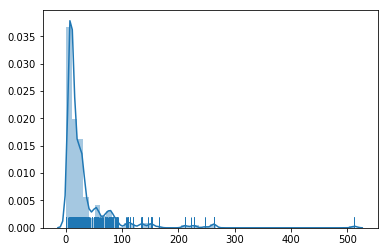

In [542]:
frp = sns.distplot(tuple(All.loc[pd.notnull(All['Survived']),'Fare']), rug=True)

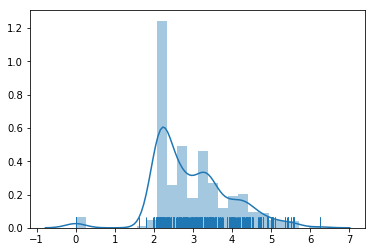

In [522]:
frp = sns.distplot(tuple(np.log1p(All.loc[pd.notnull(All['Survived']),'Fare'])), rug=True)

In [547]:
np.log1p(All.loc[pd.notnull(All['Survived']),'Fare']).describe()

count    909.000000
mean       2.970523
std        0.969563
min        0.000000
25%        2.188856
50%        2.740840
75%        3.474293
max        6.240917
Name: Fare, dtype: float64

In [646]:
All['Fare Transformed'] = np.log1p(All['Fare'])


In [470]:
All['Fare Bins'] = pd.qcut(All['Fare'],4)

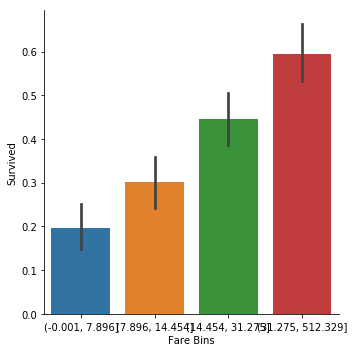

In [628]:
#there is a very nice correlation shown below, so I will make this ordinal
agp = sns.catplot(x='Fare Bins', y='Survived',data=All,kind='bar')

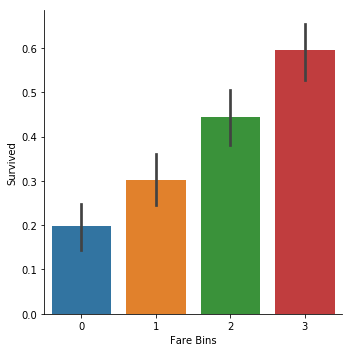

In [638]:
All['Fare Bins'] = pd.qcut(All['Fare'],4,labels=False)

In [647]:
All.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket Prefix,Name Prefix,Family,Surname,Group,Fare Transformed,Fare Bins,Age Transformed,Age Bins
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,None of any importance,Mr,1,Braund,not relevant,2.110213,0,12.210941,"(19.0, 26.0]"
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,PC,Mrs,1,Cumings,Cumings,4.280593,3,19.073538,"(30.0, 40.7]"
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,None of any importance,Miss,0,Heikkinen,Heikkinen,2.188856,1,14.018800,"(19.0, 26.0]"
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,None of any importance,Mrs,1,Futrelle,Futrelle,3.990834,3,17.852902,"(30.0, 40.7]"
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,None of any importance,Mr,0,Allen,not relevant,2.202765,1,17.852902,"(30.0, 40.7]"


### Age
Here I will make use of the boxcox transformation, so it will look like this:
$$ U = \frac{X^\lambda - 1}{\lambda}, \lambda > 0$$
$$ U = \log(X), \lambda = 0$$
 
where $X$ is Age.

In [553]:
All.loc[pd.notnull(All['Survived']),'Age'].describe()

count    909.000000
mean      28.828383
std       13.724772
min        0.420000
25%       20.000000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

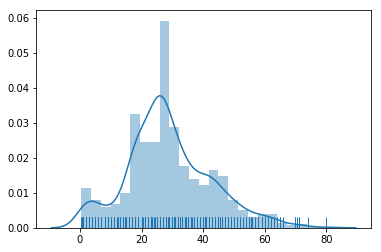

In [551]:
ap = sns.distplot(tuple(All.loc[pd.notnull(All['Survived']),'Age']), rug=True)

In [643]:
#getting the lambda value
boxcox(All.loc[pd.notnull(All['Survived']),'Age'])[1]

0.7613266366890794

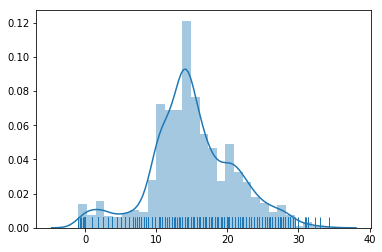

In [527]:
ap = sns.distplot(tuple(boxcox(All.loc[pd.notnull(All['Survived']),'Age'],.75)), rug=True)

In [555]:
pd.Series(boxcox(All['Age'],.75)).describe()

count    1309.000000
mean       15.028331
std         5.956382
min        -0.980333
25%        11.746530
50%        14.018800
75%        18.466356
max        34.332816
dtype: float64

In [644]:
All['Age Transformed'] = boxcox(All['Age'],.75)


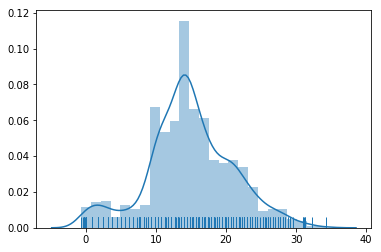

In [645]:
ap = sns.distplot(tuple(All.loc[pd.notnull(All['Survived']),'Age Transformed']), rug=True)

In [561]:
All['Age Bins'] = pd.qcut(All['Age'],5)

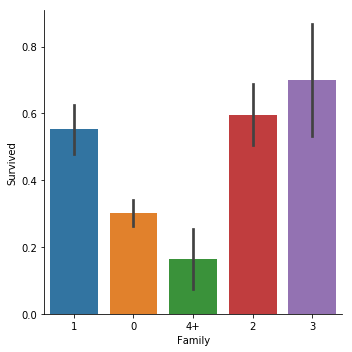

In [627]:
agp = sns.catplot(x='Family', y='Survived',data=All,kind='bar')

In [577]:
All.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket Prefix,Name Prefix,Family,Surname,Group,Fare Transformed,Fare Bins,Age Transformed,Age Bins
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,None of any importance,Mr,1,Braund,not relevant,-0.887806,"(-0.001, 7.896]",-0.434288,"(19.0, 26.0]"
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,PC,Mrs,1,Cumings,Cumings,1.351941,"(31.275, 512.329]",0.694411,"(30.0, 40.7]"
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,None of any importance,Miss,0,Heikkinen,Heikkinen,-0.806649,"(7.896, 14.454]",-0.136948,"(19.0, 26.0]"
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,None of any importance,Mrs,1,Futrelle,Futrelle,1.052921,"(31.275, 512.329]",0.493652,"(30.0, 40.7]"
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,None of any importance,Mr,0,Allen,not relevant,-0.792296,"(7.896, 14.454]",0.493652,"(30.0, 40.7]"


### Some Analysis
Age looks as as if it is better off as a categorical variable, while all other predictors seem significant for now.

In [601]:
All.groupby('Survived')['Fare'].mean()

Survived
0.0    22.294788
1.0    48.773739
Name: Fare, dtype: float64

In [649]:
#chi squared test
cat_vars = ['Age Bins', 'Family','Ticket Prefix', 'Sex', 'Name Prefix', 'Pclass', 'Embarked']
for i in range(len(cat_vars)):
    print(cat_vars[i]+':',chi2_contingency(All.groupby(['Survived', cat_vars[i]]).size().unstack())[:3])

Age Bins: (35.80170211440345, 3.1786339985172647e-07, 4)
Family: (81.9273135240938, 6.80116381868743e-17, 4)
Ticket Prefix: (22.44583926674666, 1.3364352815545918e-05, 2)
Sex: (235.13946472802687, 4.514020902858676e-53, 1)
Name Prefix: (284.2838792044706, 2.5053930050400668e-61, 3)
Pclass: (106.16753928531534, 8.831038244607212e-24, 2)
Embarked: (31.58519965571753, 1.3847170504990659e-07, 2)


In [642]:
#Kruskal test shows Age as a continuous variable is insignificant
for i in range(len(['Age','Fare','Fare Bins'])):
    print(['Age','Fare','Fare Bins'][i] + ':' ,\
          kruskal(All.loc[All['Survived'] == 1, ['Age','Fare','Fare Bins'][i]],\
                  All.loc[All['Survived'] == 0, ['Age','Fare','Fare Bins'][i]]))

Age: KruskalResult(statistic=1.9700286123470236, pvalue=0.160444824958576)
Fare: KruskalResult(statistic=93.66107939772544, pvalue=3.744521566716254e-22)
Fare Bins: KruskalResult(statistic=83.92724044786947, pvalue=5.1332333704361973e-20)


In [648]:
#One Way ANOVA, although neither of these variables look to be normally distributed enough for this to be accurate
for i in range(len(['Age Transformed','Fare Transformed'])):
    print(['Age Transformed','Fare Transformed'][i] + ':' ,\
          f_oneway(All.loc[All['Survived'] == 1, ['Age Transformed','Fare Transformed'][i]],\
                  All.loc[All['Survived'] == 0, ['Age Transformed','Fare Transformed'][i]]))

Age Transformed: F_onewayResult(statistic=5.812557425365078, pvalue=0.016110072025779694)
Fare Transformed: F_onewayResult(statistic=108.90951668129466, pvalue=3.7167954130501414e-24)


In [622]:
pd.get_dummies(All[['Fare Bins', 'Pclass', 'Name Prefix']], drop_first=False)

,Pclass,"Fare Bins_(-0.001, 7.896]","Fare Bins_(7.896, 14.454]","Fare Bins_(14.454, 31.275]","Fare Bins_(31.275, 512.329]",Name Prefix_Master,Name Prefix_Miss,Name Prefix_Mr,Name Prefix_Mrs
0,3,1,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,1
2,3,0,1,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,1
4,3,0,1,0,0,0,0,1,0
5,3,0,1,0,0,0,0,1,0
6,1,0,0,0,1,0,0,1,0
7,3,0,0,1,0,1,0,0,0
8,3,0,1,0,0,0,0,0,1
9,2,0,0,1,0,0,0,0,1


## Finding the best model 

In [731]:
Y_train = All.loc[pd.notnull(All['Survived']), ['Survived','PassengerId']].set_index('PassengerId')
Y_train = Y_train['Survived']
Y_test = All.loc[pd.isnull(All['Survived']), ['Survived','PassengerId']].set_index('PassengerId')
Y_test = Y_test['Survived']
df_train = All.loc[pd.notnull(All['Survived']), ['Fare Bins','Age Bins','Fare Transformed','Family','Ticket Prefix','Sex','Name Prefix',\
                                              'Pclass','Embarked','PassengerId','Survived']].set_index('PassengerId')
df_test = All.loc[pd.isnull(All['Survived']), ['Fare Bins','Age Bins','Fare Transformed','Family','Ticket Prefix','Sex','Name Prefix',\
                                              'Pclass','Embarked','PassengerId','Survived']].set_index('PassengerId')


df_train = pd.get_dummies(df_train, columns=cat_vars, drop_first=True)
df_test = pd.get_dummies(df_test, columns=cat_vars, drop_first=True)

df_train.drop(columns=['Survived'], inplace=True)
df_test.drop(columns=['Survived'], inplace=True)

I will try one dataframe with the Fare transformed and the other with the Fare binned.

In [732]:
X_train1 = df_train.drop(columns=['Fare Bins'])
X_test1 = df_test.drop(columns=['Fare Bins'])
X_train2 = df_train.drop(columns=['Fare Transformed'])
X_test2 = df_test.drop(columns=['Fare Transformed'])

Now I will standardize the data. Standardizing will be useful for methods such as logistic regression, linear discriminant analysis, and k nearest neighbors. 
Standardization will do the following transform:
$$ z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}$$ 
for the $i$th observation and $j$th feature, where $\mu$ is the mean and $\sigma$ is the standard deviation.

In [733]:
scale = Normalizer()
X_train1 = scale.fit_transform(X_train1)
X_test1 = scale.transform(X_test1)
X_train2 = scale.fit_transform(X_train2)
X_test2 = scale.transform(X_test2)


In [ ]:
best_vals1 = {}
best_vals2 = {}

### K Nearest Neighbors

In [799]:
params_knn = {'n_neighbors':[3,4,5,6,7,10,13,16,20,25], 'weights':['uniform','distance'], 'algorithm':['brute']}
gridCV_knn = GridSearchCV(KNeighborsClassifier(), params_knn, 'accuracy', iid=False, cv=10, \
                          verbose=True, refit='accuracy', n_jobs=3)
gridCV_knn.fit(X_train1,Y_train)
best_knn1 = gridCV_knn.best_estimator_
best_vals1['knn'] = best_knn1.best_score_
print(gridCV_knn.best_estimator_)
print(gridCV_knn.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.7s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_neighbors': [3, 4, 5, 6, 7, 10, 13, 16, 20, 25], 'weights': ['uniform', 'distance'], 'algorithm': ['brute']},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring='accuracy', verbose=True)

In [790]:
gridCV_knn.fit(X_train2,Y_train)
best_knn2 = gridCV_knn.best_estimator_
best_vals2['knn'] = best_knn2.best_score_
print(gridCV_knn.best_estimator_)
print(gridCV_knn.best_score_)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')
0.825091575091575


### Support Vector Machine

In [800]:
kernels = ['linear','poly','rbf']
cost = [.01,.1,1,5,10,50,100,500,1000]
gamma = [.001,.01,.05,.1,.5,1,5,10,50,100]
params_svm = {'C':cost ,'kernel':kernels, 'degree':[2,3,4], 'gamma':gamma, 'coef0':[0,1]}
gridCV_svm = GridSearchCV(SVC(), params_svm, 'accuracy', iid=False, cv=10, \
                          verbose=True, n_jobs=3)
gridCV_svm.fit(X_train1,Y_train)
best_svm1 = gridCV_svm.best_estimator_
best_vals1['svm'] = best_svm1.best_score_
print(gridCV_svm.best_estimator_)
print(gridCV_svm.best_score_)

Fitting 10 folds for each of 1620 candidates, totalling 16200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 314 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 1514 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 2948 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 4479 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 6309 tasks      | elapsed: 10.8min
[Parallel(n_jobs=3)]: Done 8117 tasks      | elapsed: 19.1min
[Parallel(n_jobs=3)]: Done 10134 tasks      | elapsed: 37.6min
[Parallel(n_jobs=3)]: Done 11907 tasks      | elapsed: 67.6min
[Parallel(n_jobs=3)]: Done 13491 tasks      | elapsed: 134.5min
[Parallel(n_jobs=3)]: Done 14908 tasks      | elapsed: 235.9min
[Parallel(n_jobs=3)]: Done 16200 out of 16200 | elapsed: 310.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'C': [0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100], 'coef0': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [801]:
gridCV_svm.fit(X_train2,Y_train)
best_svm2 = gridCV_svm.best_estimator_
best_vals2['svm'] = best_svm2.best_score_
print(gridCV_svm.best_estimator_)
print(gridCV_svm.best_score_)

SVC(C=5, cache_size=200, class_weight=None, coef0=0,
  decision_function_shape='ovr', degree=2, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8327960927960927


### Linear Discriminant Analysis

In [813]:

tol_lda = [.1,1.0e-2,1.0e-3,1.0e-4,1.0e-5]
params_lda = {'tol':tol_lda}
gridCV_lda = GridSearchCV(LinearDiscriminantAnalysis(), params_lda,'accuracy', iid=False, cv=10, verbose=True, n_jobs=3)
gridCV_lda.fit(X_train1,Y_train)
best_lda1 = gridCV_lda.best_estimator_
best_vals1['lda'] = best_lda1.best_score_
print(gridCV_lda.best_estimator_)
print(gridCV_lda.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [814]:
gridCV_lda.fit(X_train2,Y_train)
best_lda2 = gridCV_lda.best_estimator_
best_vals2['lda'] = best_lda2.best_score_
print(gridCV_lda.best_estimator_)
print(gridCV_lda.best_score_)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.01)
0.825091575091575


### Quadratic Discriminant Analysis

In [811]:
tol_qda = [.1,.01,.001,1e-4,1e-5]
params_qda = {'tol':tol_qda}
gridCV_qda = GridSearchCV(QuadraticDiscriminantAnalysis(), params_qda, 'accuracy', iid=False, cv=10, verbose=True, n_jobs=3)
gridCV_qda.fit(X_train1,Y_train)
best_qda1 = gridCV_qda.best_estimator_
best_vals1['qda'] = best_qda1.best_score_
print(gridCV_qda.best_estimator_)
print(gridCV_qda.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [812]:
gridCV_svm.fit(X_train2,Y_train)
best_qda2 = gridCV_qda.best_estimator_
best_vals2['qda'] = best_qda2.best_score_
print(gridCV_qda.best_estimator_)
print(gridCV_qda.best_score_)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.1)
0.7965323565323565


### Logistic Regression

In [820]:
penalty = ['none','l1','l2']
tol_glm = [.1,.01,.001,1e-4,1e-5]
C = [.001,.01,.1,1,5,10,50,100,500,1000]
params_glm = {'penalty':penalty, 'tol':tol_glm, 'C':C}
gridCV_glm = GridSearchCV(LogisticRegression(), params_glm,'accuracy',iid=False,verbose=True,n_jobs=3,error_score =0,cv=10)
gridCV_glm.fit(X_train1,Y_train)
best_glm1 = gridCV_glm.best_estimator_
best_vals1['glm'] = best_glm1.best_score_
print(gridCV_glm.best_estimator_)
print(gridCV_glm.best_score_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 1500 out of 1500 | elapsed:    4.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score=0,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'penalty': ['none', 'l1', 'l2'], 'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [821]:
gridCV_glm.fit(X_train2,Y_train)
best_glm2 = gridCV_glm.best_estimator_
best_vals2['glm'] = best_glm2.best_score_
print(gridCV_glm.best_estimator_)
print(gridCV_glm.best_score_)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.01, verbose=0, warm_start=False)
0.8360805860805861


### Boosting

In [826]:
learn_rate=[.5,.2,.1,.05,.01,.002,.0001]
num_trees_boost=[100,500,1000,5000,10000]
min_samples_leaf_boost = [10,50,100,150]
max_depth_boost = [2,4,6,8]
max_features_boost = ['sqrt',.1,.5,None]
params_boost ={'learning_rate':learn_rate, 'n_estimators':num_trees_boost, 'min_samples_leaf':min_samples_leaf_boost, 'max_depth':max_depth,\
              'max_features':max_features}
gridCV_boost = GridSearchCV(GradientBoostingClassifier(),params_boost,'accuracy',iid=False,verbose=True,n_jobs=3,cv=10)
gridCV_boost.fit(X_train1,Y_train)
best_boost1 = gridCV_boost.best_estimator_
best_vals1['boost'] = best_boost1.best_score_
print(gridCV_boost.best_estimator_)
print(gridCV_boost.best_score_)

Fitting 10 folds for each of 2240 candidates, totalling 22400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  8.5min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 14.3min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 21.5min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 30.2min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 35.9min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 44.6min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 55.6min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 66.2min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 77.3min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 93.2min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 105.1m

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'learning_rate': [0.5, 0.2, 0.1, 0.05, 0.01, 0.002, 0.0001], 'n_estimators': [100, 500, 1000, 5000, 10000], 'min_samples_leaf': [10, 50, 100, 150], 'max_depth': [2, 4, 6, 8], 'max_features': ['sqrt', 0.1, 0.5, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [827]:
gridCV_boost.fit(X_train2,Y_train)
best_boost2 = gridCV_boost.best_estimator_
best_vals2['boost'] = best_boost2.best_score_
print(gridCV_boost.best_estimator_)
print(gridCV_boost.best_score_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.8482539682539683


### Bagging

In [831]:
num_trees_bag=[100,500,1000,5000,10000]
oob_score_boost = [True,False]
max_features_bag = [.1,.3,.5,.7,.9,1.0]
params_bag = {'n_estimators':num_trees_bag, 'max_features':max_features_boost, 'oob_score':oob_score_boost}
gridCV_bag = GridSearchCV(BaggingClassifier(),params_bag,'accuracy',iid=False,verbose=True,n_jobs=3,cv=10)
gridCV_bag.fit(X_train1,Y_train)
best_bag1 = gridCV_bag.best_estimator_
best_vals1['bag'] = best_bag1.best_score_
print(gridCV_bag.best_estimator_)
print(gridCV_bag.best_score_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   20.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.7min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 19.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'n_estimators': [100, 500, 1000, 5000, 10000], 'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [832]:
gridCV_bag.fit(X_train2,Y_train)
best_bag2 = gridCV_bag.best_estimator_
best_vals2['bag'] = best_bag2.best_score_
print(gridCV_bag.best_estimator_)
print(gridCV_bag.best_score_)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.5, max_samples=1.0,
         n_estimators=500, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
0.836117216117216


### Random Forest

In [842]:
num_trees=[100,500,1000,5000]
criterion = ['gini','entropy']
max_depth = [2,4,8,None]
min_samples_split=[2,5,10]
min_samples_leaf = [1,5,10]
max_features = [.1,'sqrt',.33,.5,.8,None]
oob_score = [True,False]

params_rf = {'n_estimators':num_trees, 'criterion':criterion, 'max_depth':max_depth, 'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf, 'max_features':max_features, 'oob_score':oob_score}
gridCV_rf = GridSearchCV(RandomForestClassifier(),params_rf,'accuracy',iid=False,verbose=True,n_jobs=3,cv=10)
gridCV_rf.fit(X_train1,Y_train)
best_rf1 = gridCV_rf.best_estimator_
best_vals1['rf'] = best_rf1.best_score_
print(gridCV_rf.best_estimator_)
print(gridCV_rf.best_score_)

Fitting 10 folds for each of 3456 candidates, totalling 34560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   17.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  5.1min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  8.0min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 11.9min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 16.8min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 23.2min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 30.9min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 38.1min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 46.3min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 56.9min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 71.6min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 83.0min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 97.5mi

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'n_estimators': [100, 500, 1000, 5000], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_features': [0.1, 'sqrt', 0.33, 0.5, 0.8, None], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [843]:
gridCV_rf.fit(X_train2,Y_train)
best_rf2 = gridCV_rf.best_estimator_
best_vals2['rf'] = best_rf2.best_score_
print(gridCV_rf.best_estimator_)
print(gridCV_rf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8503907203907204


### Adaptive Boosting

In [846]:
criterion = ['gini','entropy']
splitter = ['best','random']
max_depth = [1,2,4,8,10,None] 
num_trees = [1,2,5,10,50]
learn_rate = [1,.5,.2,.1,.05,.01,.001,.0001]
alg = ['SAMME','SAMME.R']

params_ada = {'base_estimator__criterion':criterion, 'base_estimator__splitter':splitter, 'base_estimator__max_depth':max_depth,
             'n_estimators':num_trees, 'learning_rate':learn_rate, 'algorithm':alg}
gridCV_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),params_ada,'accuracy',iid=False,
                          verbose=True, n_jobs=3,cv=10)
gridCV_ada.fit(X_train1,Y_train)
best_ada1 = gridCV_ada.best_estimator_
best_vals1['ada'] = best_ada1.best_score_
print(gridCV_ada.best_estimator_)
print(gridCV_ada.best_score_)

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 188 tasks      | elapsed:   18.3s
[Parallel(n_jobs=3)]: Done 3680 tasks      | elapsed:   45.4s
[Parallel(n_jobs=3)]: Done 6680 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 10528 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 17301 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 19200 out of 19200 | elapsed:  3.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'base_estimator__max_depth': [1, 2, 4, 8, 10, None], 'n_estimators': [1, 2, 5, 10, 50], 'learning_rate': [1, 0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', 

In [847]:
gridCV_ada.fit(X_train2,Y_train)
best_ada2 = gridCV_ada.best_estimator_
best_vals2['ada'] = best_ada2.best_score_
print(gridCV_ada.best_estimator_)
print(gridCV_ada.best_score_)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.5, n_estimators=10, random_state=None)
0.846007326007326


### Extra Trees

In [854]:
num_trees=[100,500,1000,5000]
criterion = ['gini','entropy']
max_depth = [2,4,8,None]
min_samples_split=[2,5,10]
min_samples_leaf = [1,5,10]
max_features = [.1,'sqrt',.33,.5,.8,None]


params_et = {'n_estimators':num_trees, 'criterion':criterion, 'max_depth':max_depth, 'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf, 'max_features':max_features, 'oob_score':oob_score, 'bootstrap':[True]}
gridCV_et = GridSearchCV(ExtraTreesClassifier(),params_et,'accuracy',iid=False,verbose=True,n_jobs=3,cv=10)
gridCV_et.fit(X_train1,Y_train)
best_et1 = gridCV_et.best_estimator_
best_vals1['et'] = best_et1.best_score_
print(gridCV_ada.best_estimator_)
print(gridCV_ada.best_score_)

Fitting 10 folds for each of 3456 candidates, totalling 34560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 10.2min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 14.1min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 18.8min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 24.1min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 29.7min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 36.2min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 43.9min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 52.7min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 61.5min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 71.9mi

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'n_estimators': [100, 500, 1000, 5000], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_features': [0.1, 'sqrt', 0.33, 0.5, 0.8, None], 'oob_score': [True, False], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [855]:
gridCV_et.fit(X_train2,Y_train)
best_et2 = gridCV_et.best_estimator_
best_vals2['et'] = best_et2.best_score_
print(gridCV_ada.best_estimator_)
print(gridCV_ada.best_score_)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.8437973137973138


In [ ]:
print(best_vals1)
print(best_vals2)

In [863]:
subm = pd.DataFrame(Y_test)
subm['Survived']= # predict whatever model and train set here
Added_obs = All.loc[All['PassengerId'].isin(survivor_boys_PassIds+dead_test_female_passids.tolist()), ['PassengerId','Survived']]
Added_obs.set_index('PassengerId', inplace=True)
subm = subm.append(Added_obs)
subm.sort_index(inplace=True)
subm['Survived'] = subm['Survived'].astype(int)
subm.to_csv(r"...\subm.csv")

## Conclusion
There a number of things one can do in addition to all these to get a score better than what this notebook gives(around 80%),
These include but are not limited to,

- holding out a validation set in before doing cross validation to get an accurate estimate for a leaderboard score and also help prevent overfitting
- doing variable selection to see which subset of predictors are help with accuracy
- trying out other transformations, such as normalization
- fitting other models, such as a nueral network
- ensembling a group of well performing models to get a better score
- trying to detect outliers and high leverage points and exclude them